In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

In [2]:
datafile_train="/Users/Namdeo/Downloads/counterfeit_train.csv"
datafile_test="/Users/Namdeo/Downloads/counterfeit_test.csv"
bd_train=pd.read_csv(datafile_train)
bd_test=pd.read_csv(datafile_test)

In [3]:
bd_train.head()

,Medicine_ID,Counterfeit_Weight,DistArea_ID,Active_Since,Medicine_MRP,Medicine_Type,SidEffect_Level,Availability_rating,Area_Type,Area_City_Type,Area_dist_level,Counterfeit_Sales
0,RRA15,13.100,Area046,1995,160.2366,Antimalarial,critical,0.070422,DownTown,Tier 1,Small,1775.5026
1,YVV26,NaN,Area027,1983,110.4384,Mstablizers,mild,0.013000,CityLimits,Tier 3,Medium,3069.1520
2,LJC15,9.025,Area046,1995,259.4092,Cardiac,mild,0.060783,DownTown,Tier 1,Small,2603.0920
3,GWC40,11.800,Area046,1995,99.9830,OralContraceptives,mild,0.065555,DownTown,Tier 1,Small,1101.7130
4,QMN13,NaN,Area019,1983,56.4402,Hreplacements,critical,0.248859,MidTownResidential,Tier 1,Small,158.9402


In [4]:
bd_train.isnull().sum()

Medicine_ID               0
Counterfeit_Weight     1166
DistArea_ID               0
Active_Since              0
Medicine_MRP              0
Medicine_Type             0
SidEffect_Level           0
Availability_rating       0
Area_Type                 0
Area_City_Type            0
Area_dist_level           0
Counterfeit_Sales         0
dtype: int64

In [92]:
bd_train['Medicine_MRP'].max()

277.1884

In [40]:
bd_train['Active_Since'].nunique()

9

In [5]:
bd_train.shape

(6818, 12)

In [6]:
bd_train.dtypes

Medicine_ID             object
Counterfeit_Weight     float64
DistArea_ID             object
Active_Since             int64
Medicine_MRP           float64
Medicine_Type           object
SidEffect_Level         object
Availability_rating    float64
Area_Type               object
Area_City_Type          object
Area_dist_level         object
Counterfeit_Sales      float64
dtype: object

In [7]:
bd_train.describe()

,Counterfeit_Weight,Active_Since,Medicine_MRP,Availability_rating,Counterfeit_Sales
count,5652.000000,6818.000000,6818.000000,6818.000000,6818.000000
mean,14.115057,1995.836316,151.401518,0.079174,2280.583480
std,4.649668,8.368979,62.203961,0.051481,1693.354404
min,5.855000,1983.000000,41.790000,0.013000,146.290000
25%,9.995000,1985.000000,104.509400,0.040058,933.265600
50%,13.800000,1997.000000,153.195700,0.066955,1902.670400
75%,18.050000,2002.000000,196.148350,0.107697,3207.638400
max,22.650000,2007.000000,277.188400,0.341391,13199.964800


In [8]:
for col in [ 'Medicine_ID']:
    bd_train.drop(col,1,inplace=True)
    bd_test.drop(col,1,inplace=True)

In [9]:
for col in ['Medicine_Type','SidEffect_Level','Area_Type','Area_City_Type','Area_dist_level',"DistArea_ID"]:  
    temp=pd.get_dummies(bd_train[col],prefix=col,drop_first=True)
    bd_train=pd.concat([temp,bd_train],1)
    bd_train.drop([col],1,inplace=True)
    
    temp=pd.get_dummies(bd_test[col],prefix=col,drop_first=True)
    bd_test=pd.concat([temp,bd_test],1)
    bd_test.drop([col],1,inplace=True)

In [46]:
bd_train.isnull().sum()

DistArea_ID_Area013                    0
DistArea_ID_Area017                    0
DistArea_ID_Area018                    0
DistArea_ID_Area019                    0
DistArea_ID_Area027                    0
DistArea_ID_Area035                    0
DistArea_ID_Area045                    0
DistArea_ID_Area046                    0
DistArea_ID_Area049                    0
Area_dist_level_Medium                 0
Area_dist_level_Small                  0
Area_dist_level_Unknown                0
Area_City_Type_Tier 2                  0
Area_City_Type_Tier 3                  0
Area_Type_DownTown                     0
Area_Type_Industrial                   0
Area_Type_MidTownResidential           0
SidEffect_Level_mild                   0
Medicine_Type_Antacids                 0
Medicine_Type_Antibiotics              0
Medicine_Type_Antifungal               0
Medicine_Type_Antimalarial             0
Medicine_Type_Antipyretics             0
Medicine_Type_Antiseptics              0
Medicine_Type_An

In [10]:
missing_col = ['Counterfeit_Weight']

for i in missing_col:
    bd_train.loc[bd_train.loc[:,i].isnull(),i]=bd_train.loc[:,i].mean()

In [11]:
missing_col = ['Counterfeit_Weight']

for i in missing_col:
    bd_test.loc[bd_test.loc[:,i].isnull(),i]=bd_test.loc[:,i].mean()

In [12]:
target='Counterfeit_Sales'

In [13]:
x_train=bd_train.drop(target,1)
y_train=bd_train[target]

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [15]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.5f} (std: {1:.5f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [16]:
param_dist = {"n_estimators":[50,100,200],
              "max_features": [2,4,5,6,8],
              "bootstrap": [True, False],
                'max_depth':[None,5,10,15,20,30,50,70],
                'min_samples_leaf':[1,2,5,10,15,20], 
                'min_samples_split':[2,5,10,15,20]
                  }

In [17]:
reg=RandomForestRegressor()

In [18]:
n_iter_search = 10
random_search=RandomizedSearchCV(reg,
                                 cv=10,
                                 param_distributions=param_dist,
                                 scoring='neg_mean_absolute_error',
                                 n_iter=10,n_jobs=-1,verbose=20
                                    )

In [19]:
random_search.fit(x_train,y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_st...


In [20]:
report(random_search.cv_results_,5)

Model with rank: 1
Mean validation score: -766.18519 (std: 23.81878)
Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 8, 'max_depth': 15, 'bootstrap': True}

Model with rank: 2
Mean validation score: -776.40225 (std: 24.83259)
Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 20, 'max_features': 8, 'max_depth': None, 'bootstrap': False}

Model with rank: 3
Mean validation score: -783.28854 (std: 23.01478)
Parameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 6, 'max_depth': 50, 'bootstrap': True}

Model with rank: 4
Mean validation score: -829.02814 (std: 28.80106)
Parameters: {'n_estimators': 200, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': 5, 'max_depth': 10, 'bootstrap': False}

Model with rank: 5
Mean validation score: -839.54000 (std: 22.11945)
Parameters: {'n_estimators': 200, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 2

In [68]:
submissions=pd.DataFrame({target:random_search.predict(bd_test)})

In [69]:
submissions.to_csv('isha_P3_part2.csv',index=False)

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

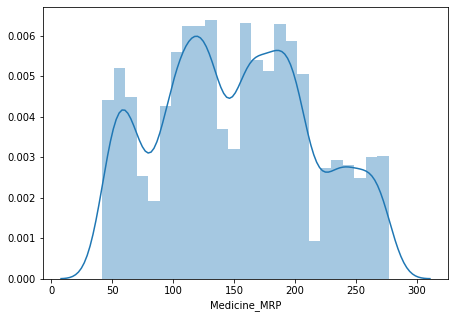

In [79]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(bd_train['Medicine_MRP'])
plt.show()

In [21]:
bd_train[(bd_train['Medicine_MRP'] > 338.01] 


SyntaxError: invalid syntax (<ipython-input-21-12a980b286b3>, line 1)

In [82]:
print("Highest allowed",bd_train['Medicine_MRP'].mean()+ 3*bd_train['Medicine_MRP'].std())
print("Lowest allowed",bd_train['Medicine_MRP'].mean()-3*bd_train['Medicine_MRP'].std())

Highest allowed 338.0134027253629
Lowest allowed -35.21036599904963
